# Import Block

In [16]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from botorch.models import SingleTaskGP
from botorch.cross_validation import CVFolds
from botorch.cross_validation import CVResults
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# Preprocessing of Data

In [27]:
# Reads in data from auto-mpg.data
columns = ['Mpg', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year',
          'Origin', 'Car Name']
data = pd.read_fwf('auto-mpg.data', names = columns)

# Drops the column car name and any row with a missing data
data = data.drop('Car Name', axis=1)
data_drop = data[data['Horsepower'] == '?'].index
data.drop(data_drop, inplace=True)
data['Horsepower'] = data['Horsepower'].astype(float)

# Splits it into MPG (Y) and Variables (X)
y = data.iloc[:,0].to_numpy()
x = data.drop('Mpg', axis=1).to_numpy()

# Further splits into train dataset and test dataset
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2)

# Scaler class for the X of data (fits scaler to train and then transforms both train and test)
x_scaler = MinMaxScaler()

# Scales the train and test dataset then turns all data into torch tensors
X_train = torch.tensor(x_scaler.fit_transform(X_train))
X_test = torch.tensor(x_scaler.transform(X_test))
Y_train = torch.tensor(Y_train.reshape(-1, 1))
Y_test = torch.tensor(Y_test.reshape(-1, 1))

# Calls CVFolds of botorch to use for cross validation
cv_folds = CVFolds(X_train, X_test, Y_train, Y_test)

# Create and fit model then perform cross validation

In [28]:
# Instantiate and fit model
cv_results = batch_cross_validation(
    model_cls=SingleTaskGP,
    mll_cls=ExactMarginalLogLikelihood,
    cv_folds=cv_folds,
)

C:\Users\cagui\miniconda3\Lib\site-packages\botorch\optim\utils\common.py:31: UserWarning: Keyword arguments ['train_Yvar'] will be ignored because they are not allowed parameters for function SingleTaskGP. Allowed parameters are ['train_X', 'train_Y', 'likelihood', 'covar_module', 'mean_module', 'outcome_transform', 'input_transform'].
  warn(
C:\Users\cagui\miniconda3\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([23.3540], dtype=torch.float64), std = tensor([7.8985], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


# Creates graph showing predicted values and their errors

Cross-validation RMSE: 2.1794832664871127


<ErrorbarContainer object of 3 artists>

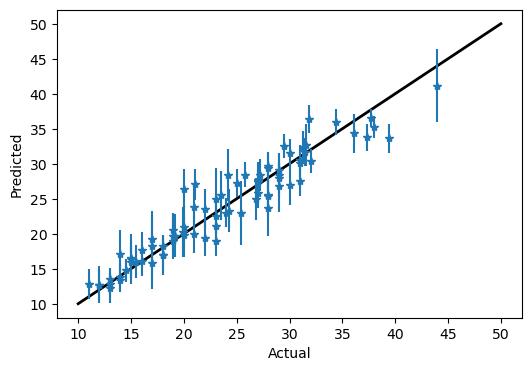

In [34]:
# Calls the posterior and mean of the cv_results
posterior = cv_results.posterior # Allows us to get distribution objects from our model
mean = posterior.mean # Gives us the predicted Y using the model
cv_error = np.sqrt(sum(((cv_folds.test_Y.numpy().flatten() - mean.numpy().flatten()) ** 2))/len(mean)) # Calculates the RMSE
print(f"Cross-validation RMSE: {cv_error}")

# Get lower and upper confidence bounds
lower, upper = posterior.mvn.confidence_region()

# Scatterplot of predicted versus test
_, axes = plt.subplots(1, 1, figsize=(6, 4))
plt.plot([10, 50], [10, 50], "k", label="true objective", linewidth=2)

# Creates axes labels
axes.set_xlabel("Actual")
axes.set_ylabel("Predicted")

# Adds points with errorbars indicating the predicted values and whether their actual value is within the error
axes.errorbar(
    x=cv_folds.test_Y.numpy().flatten(),
    y=mean.numpy().flatten(),
    yerr=((upper - lower) / 2).numpy().flatten(),
    fmt="*",
)

# Shows the table of the test dataset, their predicted Mpgs and corresponding errors

In [36]:
# Creates a dict to be printed as a table
lower, upper = posterior.mvn.confidence_region()
yerr=((upper - lower) / 2).numpy().flatten()
values = cv_folds.test_X.detach().numpy()
actual_mpgs = cv_folds.test_Y.numpy().flatten()
predicted_mpgs = mean.numpy().flatten()
columns = {'Cylinders': values[:, 0] , 'Displacement': values[:, 1], 'Horsepower': values[:, 2], 'Weight': values[:, 3],
           'Acceleration': values[:, 4], 'Model Year': values[:, 5], 'Origin': values[:, 6], 'Actual Mpgs': actual_mpgs,
           "Predicted Mpgs": predicted_mpgs, "Pred Err (+/-)": yerr}

# Prints out the table
table = pd.DataFrame(data=columns)
table

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,Actual Mpgs,Predicted Mpgs,Pred Err (+/-)
0,0.2,0.129870,0.228261,0.381060,0.521472,0.416667,0.5,23.0,21.139962,2.677572
1,0.6,0.467532,0.173913,0.555997,0.766871,0.500000,0.0,18.0,16.900346,2.815958
2,1.0,0.511688,0.429348,0.564786,0.398773,0.750000,0.0,19.2,19.736883,3.044524
3,0.2,0.023377,0.114130,0.095549,0.644172,0.333333,1.0,31.0,30.552873,2.081058
4,0.2,0.132468,0.358696,0.355826,0.429448,0.250000,0.5,19.0,20.482545,2.424861
...,...,...,...,...,...,...,...,...,...,...
74,0.6,0.420779,0.293478,0.289481,0.276074,0.083333,0.0,19.0,19.632719,3.229922
75,1.0,0.493506,0.347826,0.693791,0.644172,0.583333,0.0,17.0,18.194551,4.458569
76,0.2,0.070130,0.250000,0.191381,0.521472,0.166667,1.0,28.0,25.330038,2.237867
77,1.0,0.602597,0.456522,0.760420,0.392638,0.583333,0.0,15.0,16.578714,2.512649
